# HW 5: Monte Carlo and Integration

## Preliminaries

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats
import scipy.integrate as integrate
import scipy.special as special
import scipy.optimize as optimize

## Random Seed

In [2]:
seed=58392
gen=np.random.default_rng()

### Code

#### Mid Point Rule

In [3]:
def mid_point_rule(func, a, b, N):
    dx=(b-a)/(N+1)
    x=np.linspace(a+dx/2,b-dx/2,N)
    y=func(x)
    return dx*np.sum(y)

#### Midpoint Rule 2D

In [4]:
def mid_point_rule_2d(func, a1, b1, a2,b2, N):
    dx1=(b1-a1)/(N+1)
    dx2=(b2-a2)/(N+1)
    x1=np.linspace(a1+dx1/2,b1-dx1/2,N)
    x2=np.linspace(a2+dx2/2,b2-dx2/2,N)   
    y=func(x1[:,np.newaxis],x2[np.newaxis,:]) 
    I= np.sum(y)  
    return dx1*dx2*I

#### Transform Integral Domain

In [5]:
def integrate_transform(f_tilde,icdf,N):
	# t=icdf(u) is the inverse of u(t)
	return mid_point_rule(lambda u: f_tilde(icdf(u)),0,1,N)
    

#### Black-Scholes Formula

In [6]:
ndtr=stats.norm.cdf
epsilon=1e-12

def bs_price_fwd(isCall, K, T, F, sigma):
    """ Black's pricing formula
    
    European option  forward price as a function of
    the asset's forward.
    
    :param isCall: True for calls , False for Puts
    :type isCall: Boolean
    :param K: option strike
    :param T: option expiry in years
    :param F: forward of the options underlying asset
    :param sigma: underlying's  volatility
    :return: option's forward price
    """
    ds=np.maximum(0.000001,sigma*np.sqrt(T))
    dsig=0.5*ds*ds
    d2=(np.log(F/np.maximum(K,epsilon))-dsig)/ds
    d1=d2+ds
    if isCall:
        opt= F*ndtr(d1) - K*ndtr(d2)
    else:
        opt= K*ndtr(-d2) - F*ndtr(-d1)
    return opt

#### SVI Vol Curve Paremeterization

In [7]:
class SVICurve:
    def __init__(self,T,F,vol_ATM,b,rho,m,sigma):
        self.T=T
        self.F=F
        self.a=vol_ATM**2*T-b*(-rho*m+np.sqrt(m**2+sigma**2)) 
        self.b=b
        self.rho=rho
        self.m=m
        self.sigma=sigma        
    def __call__(self,K):
        k=np.log(K/self.F)
        var=self.a + self.b*(self.rho*(k-self.m)+np.sqrt((k-self.m)**2+self.sigma**2))
        return np.sqrt(var/self.T)

#### Risk Neutral Distribution

In [8]:
class RiskNeutral:
    def __init__(self,T,F,vol):
        self.T=T
        self.F=F
        self.vol=vol
    def cdf(self,K,dk=0.001):
        dK=K*dk
        K0=K-dK
        sig0=self.vol(K0)
        p0=bs_price_fwd(False,K0,self.T,self.F,sig0)
        K1=K+dK
        sig1=self.vol(K1)
        p1=bs_price_fwd(False,K1,self.T,self.F,sig1)
        return  (p1-p0)/dK/2.0
    def pdf(self,K,dk=0.001):
        dK=K*dk
        return (self.cdf(K)-self.cdf(K-dK))/dK       
    def ppf(self,u,tol=1e-4,max_iter=21): # inverse cdf
        T=self.T
        F=self.F
        sigma=self.vol(F)
        var=sigma**2*T
        std=np.sqrt(var)
        S=np.empty_like(u.ravel())
        
        S0=F*np.exp(-15*std)
        cdf0=self.cdf(S0)
        pdf0=self.pdf(S0)
        u1=u.ravel() #linearize into one long vector
        idx=u1.argsort() # we will visit them in increasing order
        for i1 in range(len(idx)):
            U=u1[idx[i1]]
            # solve equation  
            #    cdf(S)=u
            # using brent's method
            iter=0
            while np.abs(cdf0-U)/cdf0>tol:
                S1=S0+(U-cdf0)/pdf0
                cdf1=self.cdf(S1)
                pdf0=(cdf1-cdf0)/(S1-S0)
                cdf0=cdf1
                S0=S1
                iter+=1
                if (iter>=max_iter):
                    break
            S[idx[i1]]=S0
                    
        return S.reshape(u.shape)
    def rvs(self,gen,size,tol=1e-4,max_iter=21):
        u=gen.uniform(size=size)
        return self.ppf(u,tol,max_iter)

## Problem 1: Monte Carlo Integration

### Problem 1.1:

Whe unit  sphere is defined by equation:
$$
S^2 = \{ (u_1,u_2,u_3) \mid u_1^2 + u_2^2 + u_3^2 < 1 \}
$$

Define the sphere *indicator function* $\text{I}(u_1,u_2,u_3)$   that returns 1 if point $(u_1,u_2,u_3)$ is inside the sphere, and 0 otherwise.

In [9]:
def I_sphere(u1,u2,u3):
    pass

In [10]:
def I_sphere(u1,u2,u3):
    return (u1**2+u2**2+u3**2)<1


### Problem 1.2

Using $N=10,00$ Monte Carlo samples estimate the fraction of the *unit cube* $\Omega=(-1,1)\times (-1,1) \times (-1,1)$ that is covered by the unit sphere $S^2$:

$$
    f= \frac{ \int \int \int_{S^2} \text{d}u_1 \text{d}u_2 \text{d}u_3 } {\int \int \int_\Omega \text{d}u_1 \text{d}u_2 \text{d}u_3} = \frac{ \int_{-1}^1 \int_{-1}^1 \int_{-1}^1 \,\text{I}(u_1,u_2,u_3)\, \text{d}u_1 \text{d}u_2 \text{d}u_3 } {\int_{-1}^1 \int_{-1}^1 \int_{-1}^1 \text{d}u_1 \text{d}u_2 \text{d}u_3}
$$

where $\text{I}(u_1,u_2,u_3)$ is the indicator function for the sphere as you implemented in problem 1.1.



In [11]:
N=10_000
u1=gen.uniform(-1,1,N)
u2=gen.uniform(-1,1,N)
u3=gen.uniform(-1,1,N)

In [12]:
S=I_sphere(u1,u2,u3)
S.mean()


0.5288

### Problem 1.3

Estimate the *standard deviation* $\delta f$ of the Monte carlo estimate $\hat{f}$ of the fraction cube  occupied by the  sphere

In [13]:
S.std()/np.sqrt(N)

0.004991698708856535

Problem 1.4

1. What is the volume of the  cube $\Omega=(-1,1)\times(-1,1)\times(-1,1)$?
2. What is the Monte Carlo estimate $\hat{V}$ of the volume of the unit sphere?
3. What is the standard error $\delta V$ of the Monte Carlo estime of the sphere volume?

In [14]:
Omega=2**3
V_hat=Omega*S.mean()
dV=Omega*S.std()/np.sqrt(N)
Omega,V_hat,dV

(8, 4.2304, 0.03993358967085228)

Problem 1.5

The formula of the volume of the unit sphere is:
$$
    V = \frac{4}{3}\pi
$$

What is the probability of obtaining a Monte Carlo error $|\hat{V}-V|$ larger than the one we obtained in Problem 1.4?

[HINT] This is a **two-tailed** z-score test.

In [15]:
V=4/3*np.pi
z=(V_hat-V)/dV
p_value=2*(1-stats.norm.cdf(z))
V,V_hat,z,p_value

(4.1887902047863905, 4.2304, 1.0419748276218965, 0.2974233497129657)

###  Problem 1.6

Re-using the $N=10_000$  MC samples your generated in Problem 1.2, estimate the value of the function
$$
    f(u_1,u_2,u_3) = 10\, r(1-r)
$$ 
where 
$$
    r= \sqrt{u_1^2+u_2^2+u3^2}
$$
**in the unit sphere**:
$$
    I  =  \int \int \int_{S^2} f(u_1,u_2,u_3)
$$

In [16]:
def func(u1,u2,u3):
    ind=I_sphere(u1,u2,u3)
    r=np.sqrt(u1**2+u2**2+u3**2)
    return  10*r*(1-r)*ind


In [17]:
f=func(u1,u2,u3)
f.mean(),f.std()/np.sqrt(N)

(0.7910922587312441, 0.00938560148524196)

In [18]:
I_hat=Omega*f.mean()
dI=Omega*f.std()/np.sqrt(N)
I_hat,dI

(6.328738069849953, 0.07508481188193568)

In [19]:
I=2*np.pi # true value
(I-I_hat)/dI

-0.606684115317415

## Problem 2: Gumbel (Extreme Value Distribution)

The **Gumbel** (or Extreme Value) is the limiting distribution of of the **maximum** of $N$ independent random variables (with smoe conditions ).

The distribution has probability density function:

$$
    \text{PDF}(x) =\frac{1}{\beta} e^{-\frac{x-\mu}{\beta}}\exp\left(- e^{-\frac{x-\mu}{\beta}}\right)
$$
for $x\in (-\infty,+\infty)$

Its cumulative distribution function is:
$$
    \text{CDF}(x)= \exp \left(  -e^{-\frac{x-\mu}{\beta}} \right)
$$

### Problem 2.1

1. Implement Gumbel's PDF
2. Implement Gumbel's CDF
3. Plot the PDF and CDF of a $\text{Gumbel}(\mu=0,\beta=2)$ random variable in on the domain $x\in (-5,15)$

In [20]:
def pdf_gumbel(x,mu,beta):
    pass

In [21]:
def cdf_gumbel(x,mu,beta):
    pass

In [22]:
def pdf_gumbel(x,mu,beta):
    return 1/beta*np.exp(-(x-mu)/beta)*np.exp(-np.exp(-(x-mu)/beta))

In [23]:
def cdf_gumbel(x,mu,beta):
    return np.exp(-np.exp(-(x-mu)/beta))


In [24]:
mu=0
beta=2

Text(0, 0.5, 'PDF(x)')

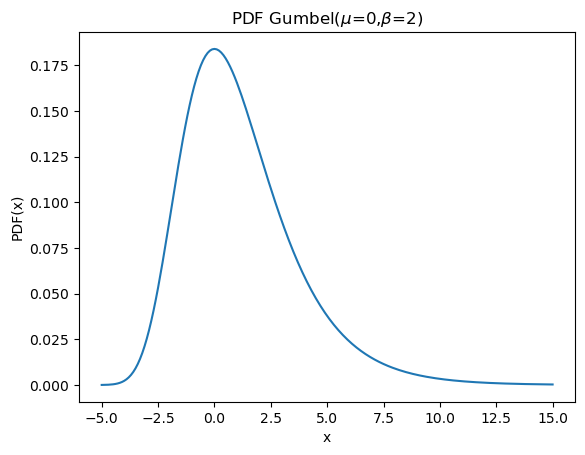

In [25]:
x=np.linspace(-5,15,201)
p=pdf_gumbel(x,mu,beta)
plt.plot(x,p)
plt.title(rf"PDF Gumbel($\mu$={mu},$\beta$={beta})")
plt.xlabel("x")
plt.ylabel("PDF(x)")

Text(0, 0.5, 'CDF(x)')

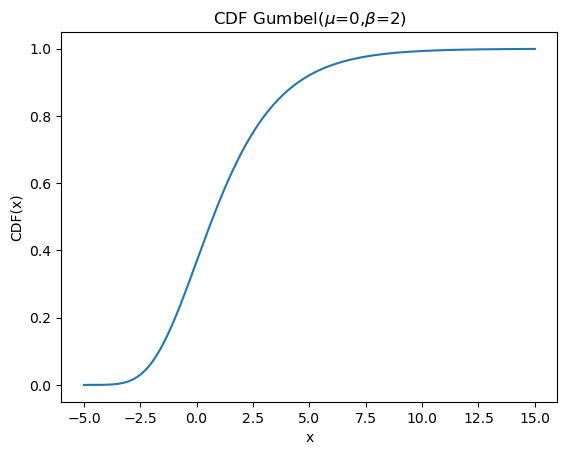

In [26]:

u=cdf_gumbel(x,mu,beta)
plt.plot(x,u)
plt.title(rf"CDF Gumbel($\mu$={mu},$\beta$={beta})")
plt.xlabel("x")
plt.ylabel("CDF(x)")

### Problem 2.2

The inverse cumulative distribution function of a Gumbel's random variable can be computed analytically:

$$
    \text{CDF}^{-1}(u) = \mu - \beta \log(-\log u)
$$

1. Implement the inverse cumulative distribution
2. Plot $\text{CDF}^{-1}(u)$ in some range $u\in (\Delta u, 1- \Delta u)$, for some small $\Delta u>0$. 
3. Why can't  we plot $\text{CDF}^{-1}(u)$ in the range $u\in(0,1)$?
4. Verify that 
$$
 x= \text{CDF}^{-1} ( \text{CDF}(x))
$$
in the range $x\in (-5,15)$

In [27]:
def icdf_gumbel(u,mu,beta):
    pass

In [28]:
def icdf_gumbel(u,mu,beta):
    return mu-beta*np.log(-np.log(u))

Text(0, 0.5, 'x')

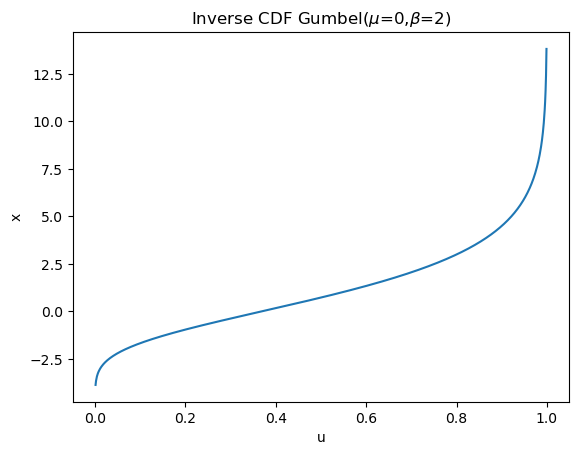

In [29]:
du=1/1000
u=np.linspace(du,1-du,1001)
plt.plot(u,icdf_gumbel(u,mu,beta))
plt.title(rf"Inverse CDF Gumbel($\mu$={mu},$\beta$={beta})")
plt.xlabel("u")
plt.ylabel("x")

In [30]:
# CDF diverges as u approaches 0 or 1 

In [31]:
x=np.linspace(-5,15,201)
u=cdf_gumbel(x,mu,beta)
error=np.abs(x-icdf_gumbel(u,mu,beta))
error.max()

1.652011860642233e-13

### Problem 2.3

Using  the **mid point rule** evaluate the expected value $\bar{x}$ of  a $\text{Gumbel}(\mu=0,\beta=2)$ random variable:

$$
    \bar{x}=\mathbb{E}_{\text{Gumbel}}[x] = \int_{-\infty,\infty}\text{d} x\, x\, \text{PDF}(x)
$$

Perform the calculation with:
1. N=100 grid points
2. N=1,000 grid points

In [32]:
integrate_transform(lambda x:x,lambda u: icdf_gumbel(u,mu,beta),100)

1.1375033425244763

In [33]:
I=integrate_transform(lambda x:x,lambda u: icdf_gumbel(u,mu,beta),1000)
I

1.1526676706574046

### Problem 2.4

Estimate the expected value $\bar{x}$  (like in problem 2.3) using [scipy.integrate.quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html)

[HINT] You can either integrate over $x$ or over $u$.

In [34]:
#integrating over x, we need to truncate the domain
I0,dI,info=integrate.quad(lambda x: x*pdf_gumbel(x,mu,beta),-100,100,full_output=True)
I0,dI,info["neval"]

(1.15443132980307, 1.3544468158155354e-08, 357)

In [35]:
# integrating over u
I0,dI,info=integrate.quad(lambda u: icdf_gumbel(u,mu,beta),0,1,full_output=True)
I0,dI,info["neval"]

(1.1544313298266349, 1.3512996055453641e-08, 567)

### Problem 2.5

Using integration evaluate the variance of $x$

$$
    \text{Var}[x] = \mathbb{E}[(x- \bar{x})^2] = \int_{-\infty}^{\infty} \text{d}x\, (x-\bar{x})^2 \text{PDF}(x)
$$

In [36]:
# variace of x
dI2=integrate_transform(lambda t:(t-I0)**2,lambda u: icdf_gumbel(u,mu,beta),1001)
dI2


6.54889798438435

### Problem 2.6

Using the result you computed in Problem 2.5, what will be the standard deviation of a $N=10,000$ samples Monte Carlo estimate of $\bar{x}$?

Do this estimate without performing any Monte Carlo sampling.

In [37]:
# standard deviation of x
dI=np.sqrt(dI2)
dI

2.559081472791429

In [38]:
# Standard deviation of the Monte Carlo
# of estimate of  the expected value of x
dI/np.sqrt(10_000)

0.02559081472791429

### Problem 2.7

1. Draw $N=10,000$ samples from a  Gumbel($mu=0$,$\beta$=2) random variable. Estimate the mean and the standard error of the estime.

2. Are the results consistent with what you expected from problems 2.3 and 2.6?

[HINT] You can use [numpy.random.Generator.gumbel](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.gumbel.html#numpy.random.Generator.gumbel) to generate the samples, or use the inverse cdf method.

In [39]:
t=gen.gumbel(scale=beta,loc=mu,size=10_000)

In [40]:
x_hat=t.mean()
dx=t.std()/np.sqrt(10_000)
x_hat,dx

(1.1771585250248786, 0.025996501645527813)

In [41]:
# the estimated estandard deviations  are close to each other
dI/np.sqrt(10_000),dx

(0.02559081472791429, 0.025996501645527813)

In [42]:
# and the mean z-score is less than 2
(x_hat-I0)/dx

0.8742405231341387

## Problem 3: Call Option on a Two Asset Basket

An European  **Basket Call option** on two assets has payout at maturity:

$$
    \text{payout}(S_1,S_2) = \max \left( \frac{1}{2}(\frac{S_1}{S_{1,0}}+\frac{S_2}{S_{2,0}}) -K ,0 \right)
$$
where $S_1$ and $S_2$ are the levels of asset $1$ and $2$ an option expiry and $S_{1,0}$ and $S_{2,0}$ are two constant *reference levels* chosen at trade date.



### Problem 3.1
Implement the option payout

In [43]:
def basket_payout(S1,S2,K,S1_0,S2_0):
    pass

In [44]:
def basket_payout(S1,S2,K,S1_0,S2_0):
    return np.maximum( 0.5*(S1/S1_0+S2/S2_0)-K,0)

### Problem 3.2

We will assume that the random variables $S_1$ and $S_2$ have **Log-Normal** distributions

Implement the **transformed** basket payout:

$$
    \widetilde{\text{payout}}(u_1,u_2) =  \text{payout}(S_1(u_1),S_2(u_2))
$$
where $S_1(u_1)$ and $S_2(u_2)$ are the inverse CDFs of the two log normal distributions

[HINTS] 
1. The variables `dist1` and `dist2` are [scipy.stats.lognorm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html) objects.
2. The **inverse cdf** of s `scipy.stats` object is implemented by the [`ppf`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.ppf.html#scipy.stats.rv_continuous.ppf) method

In [45]:
def basket_tranformed_payoff(u1,u2,K,dist1,S1_0,dist2,S2_0):
    pass

In [46]:
# analytic work of two option
def basket_tranformed_payoff(u1,u2,K,dist1,S1_0,dist2,S2_0):
    S1=dist1.ppf(u1)
    S2=dist2.ppf(u2)
    return basket_payout(S1,S2,K,S1_0,S2_0)

### Problem 3.3

For the rest of this problem we will assume that:
1. The option expiry is $T=1$.
2. The option strike is $K=1.05$
3. Asset 1 has forward $F_1=1.15$ and volatility $\sigma_1=$15\%
4. Asset 2 has forward $F_2=0.9$ and volatility $\sigma_2=$35\%
5. Asset 1 and 2 are **independent** from each other.
6. The *reference levels* are  $S_{1,0}=F_1$ and $S_{2,0}=F_2$

Define the [scipy.stats.lognorm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html) `dist1` and `dist2` distribution ojects for both objets.

[HINT] The parameters defining the  `scipy.stats.lognorm` distribution given the market data are:
1. `s`=$\sqrt{\sigma^2 T}$
2. `scale`= $F \exp\left(- \frac{1}{2}\sigma^2 T\right)$

In [47]:
T=1
K=1.05
F1=1.15
F2=0.9
sigma1=0.15
sigma2=0.35
S1_0=F1
S2_0=F2

In [48]:
var1=sigma1**2*T
var2=sigma2**2*T
dist1=stats.lognorm(s=np.sqrt(var1),scale=F1*np.exp(-0.5*var1))
dist2=stats.lognorm(s=np.sqrt(var2),scale=F2*np.exp(-0.5*var2))

### Problem 3.4

Using the 2 dimensional **mid point rule** estimate the value of the basket call option
$$
    \text{value} = \mathbb{E}_{S_1,S_2}\left[ \text{payout}(S_1,S_2)\right]= \mathbb{E}_{u_1,u_2}\left[ \widetilde{\text{payout}}(u_1,u_2)\right]
$$
1. Use an integration grid with $ 100\times 100$ points
2. Use an integration grid with $1,000 \times 1,000$ points

[HINT] You defined the payout in problems 3.1 and 3.2

In [49]:
mid_point_rule_2d(lambda u1,u2: basket_tranformed_payoff(u1,u2,K,dist1,S1_0,dist2,S2_0),0,1,0,1,100)

0.05441027808331013

In [50]:
value=mid_point_rule_2d(lambda u1,u2: basket_tranformed_payoff(u1,u2,K,dist1,S1_0,dist2,S2_0),0,1,0,1,1000)
value

0.05589773499028353

### Problem 3.5

Using integration, estimate the variance of the payout
$$
    \text{Var}[\text{payout}] = \mathbb{E}_{S_1,S_2}\left[ (\text{payout}(S_1,S_2) - \text{value})^2\right]
$$

What will by the standard deviation of the Monte Carlo estimated option price after drawing $N=10,000$ samples?

In [51]:
dI2=mid_point_rule_2d(lambda u1,u2: (basket_tranformed_payoff(u1,u2,K,dist1,F1,dist2,F2)-I)**2,0,1,0,1,100)
dI2

1.1927229638469374

In [52]:
dvalue=np.sqrt(dI2/10_000)
dvalue

0.010921185667531422

### Problem 3.6

1. Draw $N=10,000$ samples from the distributions of $S_1$ and $S_2$ and use them to estimate the basket call option price.
2. Compute the standard error of the estimate. Is it consistent with what you estimated in Problem 3.5?
3. Is the Monte Carlo option price consistent with the  value estimated by integration in problem 3.4?

In [53]:
N=10_000
S1=dist1.rvs(size=N)
S2=dist2.rvs(size=N)
pay=basket_payout(S1,S2,K,S1_0,S2_0)
pay.mean()


0.05665575951306035

In [54]:
# standard deviation of MC estimates are consistent
dvalue,pay.std()/np.sqrt(N)

(0.010921185667531422, 0.0011844616085346423)

In [55]:
# MC z-score is small
(pay.mean()-value)/dvalue

0.06940862886622441

## Bonus Problem 4: Risk Neutral Valuation of Option Prices

The  SVI volatility Curve parameters one year options in the  SPX index are 

1. Expiry $T=1$
2. Forward $F=4,200$
3. ATM volatility is 19\%
4. The other parameters of the SVI parametrization are given by:
    1. $b=.13$
    2. $\rho=-0.734$
    3. $m=.128$
    4. $\tilde{\sigma}$=0.118

as calibrated to market option data as of `2023-02-07`

### Problem 4.1

1. define the SVI volatility curve.
2. define the Risk Neutral Definition
3. Plot the inverse CDF in some range $u\in(\Delta u, 1-\Delta u)$ for $\Delta u$ small but finite

[HINT] 
1. This are the same parameters we used in Bonus Problem 4 of HW4.
2. The inverse CDF is implemented by the function `ppf` in the `RiskNeutral` object defined in the Code  section of this notebook.


In [56]:
T=1
F=4200
sigma_ATM=0.19
b=0.13
rho=-0.734
m=0.128
sigma=0.118

In [57]:
vol=SVICurve(T,F,sigma_ATM,b,rho,m,sigma)

In [58]:
dist=RiskNeutral(T,F,vol)

Text(0.5, 1.0, 'Risk Neutral Inverse CDF')

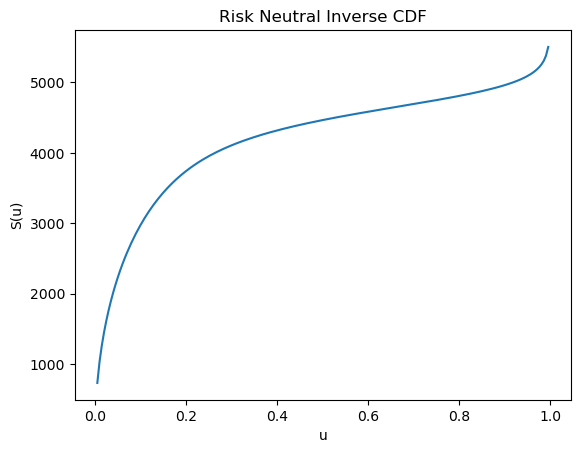

In [59]:
u=np.linspace(1/201,1-1/201,201)
plt.plot(u,dist.ppf(u))
plt.xlabel("u")
plt.ylabel("S(u)")
plt.title("Risk Neutral Inverse CDF")
    

### Problem 4.2

Define the transformed call option payout:

$$
    \widetilde{\text{payout}}(u) = \max \left( S(u)-K,0 \right)
$$
where $S(u)$ is the inverse CDF of the risk neutral distribution


In [60]:
def opt_payout(u,K,dist):
    S=dist.ppf(u)
    return np.maximum(S-K,0)

### Problem 4.3

Using integration with a mid point rule estimate the price of a call option with strike $K=4,300$ using the risk neutral.
distribution, Use $N=100$ and $N=1000$ grid points.

In [61]:
K=4300

In [62]:
mid_point_rule(lambda u: opt_payout(u,K,dist),0,1,100)

250.91946579706578

In [63]:
value=mid_point_rule(lambda u: opt_payout(u,K,dist),0,1,1000)
value

253.75658847412078

### Problem 4.4

Use Black-Scholes to price this option analytically. What was the percentage error of the numerical integration with $N=1,000$ points?

[HINT] The `SVI` parameterization give us the **implied volatlity** for each strike $\sigma(K)$

In [64]:
sig=vol(K)
sig

0.17807531360171738

In [65]:
value_exact=bs_price_fwd(True,K,T,F,sig)
value_exact

254.15057065522956

In [66]:
(value-value_exact)/value_exact

-0.0015501919987551114

### Problem 4.5

1. Generate $N=10,000$ random samples of the risk neutral distribution using the method `rvs` of the `RiskNeutral` object
2. Compute the call option price and the standard error.
3. Is the error larger or smaller than the numerical integration 

In [67]:
S=dist.rvs(gen,10_000)

In [68]:
# the error is larger
pay=np.maximum(S-K,0)
pay.mean(),pay.std()/np.sqrt(10_000)

(258.3560047406031, 2.914540248343852)

## Bonus Problem 5: Average of Two Assets, Risk Neutral Valuation

We now have a second asset with a non-flat volatility curve with parameters:
1. Forward $F_2=2,200$
3. ATM volatility is 25\%
4. The other parameters of the SVI parametrization are given by:
    1. $b_2$=.07
    2. $\rho_2$=-0.85
    3. $m_2$=0.08
    4. $\tilde{\sigma}$=0.13

### Problem 5.1

1. Define the SVI volatility curve and the RiskNeutral distribution for the second asset
2. Plot the volatility curves of both assets as a function of the percentage of forward $S/F$

In [69]:
F2=2200
sigma_ATM2=0.25
b2=0.07
rho2=-0.85
m2=0.08
sigma2=0.13

In [70]:
vol2=SVICurve(T,F2,sigma_ATM2,b2,rho2,m2,sigma2)

In [71]:
dist2=RiskNeutral(T,F2,vol2)

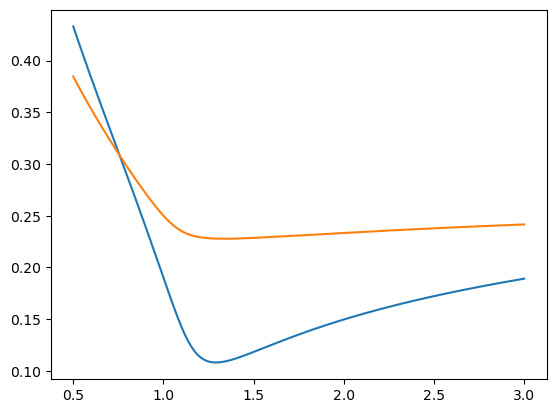

In [72]:
S1=np.linspace(0.5*F,3*F,201)
S2=np.linspace(0.5*F2,3*F2,201)
plt.plot(S1/F,dist.vol(S1))
plt.plot(S2/F2,dist2.vol(S2))

### Problem 5.2

Price a Basket Call Option
$$
    \text{payout}(S_1,S_2) = \max \left( \frac{1}{2}(\frac{S_1}{S_{1,0}}+\frac{S_2}{S_{2,0}}) -K ,0 \right)
$$
 on the two risk neutral assets  where, again the reference levels are the forwards
\begin{align*}
    S_{1,0} &= F \\
    S_{2,0} &= F_2
\end{align*}
and strike $K=1.0$
use integration with  2-dimensional mid point rule with $100\times 100$ and  $1,000\times $ grids

In [73]:
K=1.0
S1_0=F
S2_0=F2
K,S1_0,S2_0

(1.0, 4200, 2200)

In [74]:
mid_point_rule_2d(lambda u1,u2: basket_tranformed_payoff(u1,u2,K,dist,S1_0,dist2,S2_0),0,1,0,1,100)

0.06305103913503723

In [75]:
value=mid_point_rule_2d(lambda u1,u2: basket_tranformed_payoff(u1,u2,K,dist,S1_0,dist2,S2_0),0,1,0,1,1000)
value

0.06445707739333552

### Problem 5.3

Use Monte Carlo with $N=10,000$ samples to evalute the price of the option.

Are the Monte Carlo and integration values consistent with each other?


In [76]:
S1=dist.rvs(gen,size=10_000)
S2=dist2.rvs(gen,size=10_000)

In [77]:
pay=basket_payout(S1,S2,K,S1_0,S2_0)
pay.mean(),pay.std()/np.sqrt(10_000)

(0.06356517117463481, 0.0008948403072490104)

In [78]:
# the two values are within the MC standard error
(pay.mean()-value)/(pay.std()/np.sqrt(10_000))

-0.9967211037270747